# Amazon Employee Access Challenge: Predicting Access Requests

## Project Overview

This notebook addresses the **Amazon Employee Access Challenge** on Kaggle, where the goal is to predict whether an employee's access request should be approved (`ACTION=1`) or denied (`ACTION=0`). The dataset consists of categorical features related to employee roles, resources, and organizational hierarchy. The evaluation metric is the **Area Under the ROC Curve (AUC)**, as the dataset is highly imbalanced (94.2% of `ACTION` values are 1).

### Objective
Build a machine learning model to predict the probability of access approval, leveraging feature engineering, handling class imbalance, and comparing multiple models to maximize AUC.

### Dataset
- **Training Data**: 32,769 rows, 10 columns (including the target `ACTION`).
- **Test Data**: 58,921 rows, 10 columns (including `id` for submission).
- Features are categorical (encoded as integers) and represent employee roles, resources, and managerial hierarchy.
- No missing values in the dataset.

## Setup and Imports

First, we import the necessary libraries for data processing, visualization, and modeling.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Define the root path for data
root = '/home/reneosorio77/code/amazon-employee-access-challenge'

## Step 1: Load and Inspect the Data

We load the training, test, and sample submission files to understand the dataset structure.

In [75]:
# Load the data
train_df = pd.read_csv(root + '/data/train.csv')
test_df = pd.read_csv(root + '/data/test.csv')
sample_submission = pd.read_csv(root + '/data/sampleSubmission.csv')

# Display shapes and columns
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Training Columns:", train_df.columns.tolist())
print("Test Columns:", test_df.columns.tolist())

Training Data Shape: (32769, 10)
Test Data Shape: (58921, 10)
Training Columns: ['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Test Columns: ['id', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


### Check for Missing Values

In [76]:
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())


Missing Values in Training Data:
ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

Missing Values in Test Data:
id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64


### Output:
- No missing values in either the training or test data, so no imputation is needed.

## Step 2: Exploratory Data Analysis (EDA)

### Target Variable Distribution
The target `ACTION` is binary (1 for approved, 0 for denied). We check its distribution to understand the class balance.

Target Distribution:
1    0.94211
0    0.05789
Name: ACTION, dtype: float64


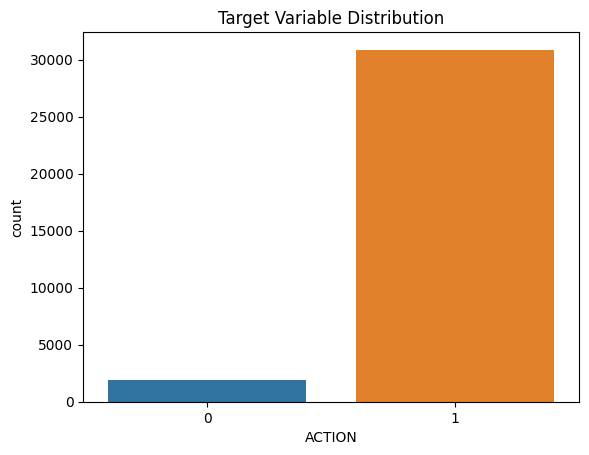

In [77]:
print("Target Distribution:")
print(train_df['ACTION'].value_counts(normalize=True))

# Visualize the distribution
sns.countplot(x='ACTION', data=train_df)
plt.title('Target Variable Distribution')
plt.show()

### Output:
- **Target Distribution**:
  - `ACTION=1`: 94.21%
  - `ACTION=0`: 5.79%

The dataset is **highly imbalanced**, with 94.21% of access requests approved. This imbalance will require techniques like SMOTE to ensure the model learns to predict the minority class (`ACTION=0`) effectively.

### Feature Intuition and Expected Impact
All features are categorical but encoded as integers. Here's the intuition behind each feature and its expected impact on predicting `ACTION`:

- **`RESOURCE`**: The resource the employee is requesting access to. Different resources may have varying approval rates based on their sensitivity or role requirements. For example, a highly restricted resource might have a lower approval rate.
- **`MGR_ID`**: The employee’s manager ID. Managers may have different approval tendencies based on their management style or department policies.
- **`ROLE_ROLLUP_1` and `ROLE_ROLLUP_2`**: High-level groupings of the employee’s role. These may indicate the employee’s position in the organizational hierarchy, which could affect access approval (e.g., higher-level roles might have more approvals).
- **`ROLE_DEPTNAME`**: The department the employee belongs to. Departments handling sensitive data (e.g., finance) might have stricter access controls.
- **`ROLE_TITLE`**: The employee’s specific job title. Certain titles may require access to specific resources, influencing approval likelihood.
- **`ROLE_FAMILY_DESC` and `ROLE_FAMILY`**: Broader categorizations of the employee’s role. These might capture patterns in access needs across similar roles.
- **`ROLE_CODE`**: A unique identifier for the employee’s role. Likely highly correlated with `ROLE_TITLE` but may provide additional granularity.

**Expected Impact**: Features like `RESOURCE`, `ROLE_TITLE`, and `ROLE_CODE` are likely to be the most predictive, as they directly relate to the specific access request and the employee’s job function. Manager and department-level features (`MGR_ID`, `ROLE_DEPTNAME`) might capture organizational policies or patterns in approvals.

## Step 3: Feature Engineering

### Target Encoding for Categorical Features
Since all features are categorical, we apply **target encoding** to convert them into numerical values based on the mean of the target (`ACTION`) for each category. This captures the relationship between each category and the likelihood of approval.

In [78]:
# Separate features and target
X = train_df.drop('ACTION', axis=1)
y = train_df['ACTION']
X_test = test_df.drop('id', axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply target encoding
global_mean = train_df['ACTION'].mean()  # For NaN filling
for col in X_train.columns:
    target_means = train_df.groupby(col)['ACTION'].mean()
    X_train[col] = X_train[col].map(target_means)
    X_val[col] = X_val[col].map(target_means).fillna(global_mean)
    X_test[col] = X_test[col].map(target_means).fillna(global_mean)

### Interaction Features
We create interaction features to capture combined effects of features that might influence access approval together, such as the employee’s role and the resource they are requesting.

In [79]:
# Add interaction features
for feature_pair in [('ROLE_TITLE', 'RESOURCE'), ('ROLE_DEPTNAME', 'RESOURCE'), 
                     ('ROLE_CODE', 'RESOURCE'), ('ROLE_TITLE', 'ROLE_DEPTNAME')]:
    new_feature = f"{feature_pair[0]}_{feature_pair[1]}"
    X_train[new_feature] = X_train[feature_pair[0]].astype(str) + '_' + X_train[feature_pair[1]].astype(str)
    X_val[new_feature] = X_val[feature_pair[0]].astype(str) + '_' + X_val[feature_pair[1]].astype(str)
    X_test[new_feature] = X_test[feature_pair[0]].astype(str) + '_' + X_test[feature_pair[1]].astype(str)

    # Apply target encoding to interaction features
    target_means = pd.concat([X_train, y_train], axis=1).groupby(new_feature)['ACTION'].mean()
    X_train[new_feature] = X_train[new_feature].map(target_means)
    X_val[new_feature] = X_val[new_feature].map(target_means).fillna(global_mean)
    X_test[new_feature] = X_test[new_feature].map(target_means).fillna(global_mean)

# Verify no NaNs remain
print("NaNs in X_train:", X_train.isna().sum().sum())
print("NaNs in X_val:", X_val.isna().sum().sum())
print("NaNs in X_test:", X_test.isna().sum().sum())

NaNs in X_train: 0
NaNs in X_val: 0
NaNs in X_test: 0


### Handling Class Imbalance with SMOTE
Given the imbalance in `ACTION`, we use **SMOTE** (Synthetic Minority Oversampling Technique) to oversample the minority class (`ACTION=0`) with a 1:15 ratio.

In [80]:
smote = SMOTE(sampling_strategy=0.0667, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training set shape after SMOTE:", X_train_resampled.shape)
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Training set shape after SMOTE: (26344, 13)
Class distribution after SMOTE:
1    0.937481
0    0.062519
Name: ACTION, dtype: float64


### Output:
- **Training set shape after SMOTE**: (26,344, 13)
- **Class distribution after SMOTE**:
  - `ACTION=1`: 93.75%
  - `ACTION=0`: 6.25%

SMOTE slightly adjusts the class distribution, making the model more sensitive to the minority class.

## Step 4: Model Training and Evaluation

We train multiple models and evaluate them using AUC, the competition’s metric. We also define a helper function to evaluate each model.

In [81]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    print(f"{model.__class__.__name__} Validation AUC: {auc:.4f}")
    y_val_pred_binary = (y_val_pred > 0.5).astype(int)
    print(f"\nClassification Report for {model.__class__.__name__}:")
    print(classification_report(y_val, y_val_pred_binary))
    return model, auc, y_val_pred

results = {}

# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg_model, logreg_auc, logreg_val_pred = evaluate_model(logreg, X_train_resampled, y_train_resampled, X_val, y_val)
results['LogisticRegression'] = logreg_auc

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model, rf_auc, rf_val_pred = evaluate_model(rf, X_train_resampled, y_train_resampled, X_val, y_val)
results['RandomForest'] = rf_auc

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model, xgb_auc, xgb_val_pred = evaluate_model(xgb, X_train_resampled, y_train_resampled, X_val, y_val)
results['XGBoost'] = xgb_auc

# LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm_model, lgbm_auc, lgbm_val_pred = evaluate_model(lgbm, X_train_resampled, y_train_resampled, X_val, y_val)
results['LightGBM'] = lgbm_auc

# CatBoost
catboost = CatBoostClassifier(random_state=42, verbose=0)
catboost_model, catboost_auc, catboost_val_pred = evaluate_model(catboost, X_train_resampled, y_train_resampled, X_val, y_val)
results['CatBoost'] = catboost_auc

LogisticRegression Validation AUC: 0.9270

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.65      0.46      0.54       379
           1       0.97      0.98      0.98      6175

    accuracy                           0.95      6554
   macro avg       0.81      0.72      0.76      6554
weighted avg       0.95      0.95      0.95      6554

RandomForestClassifier Validation AUC: 0.9180

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.82      0.46      0.59       379
           1       0.97      0.99      0.98      6175

    accuracy                           0.96      6554
   macro avg       0.89      0.73      0.78      6554
weighted avg       0.96      0.96      0.96      6554

XGBClassifier Validation AUC: 0.9585

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.77   

### Model Comparison with ROC Curves
We plot the ROC curves for all models to compare their performance visually.

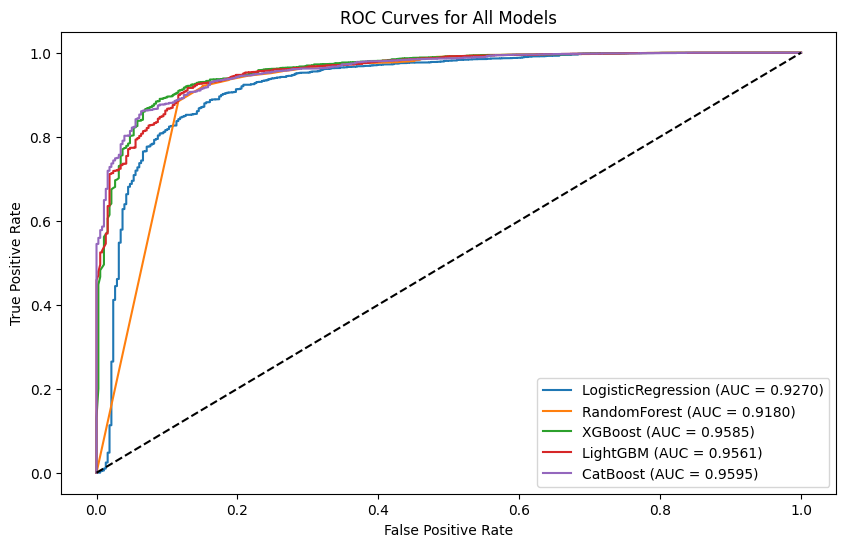

In [82]:
plt.figure(figsize=(10, 6))
for model_name, y_pred in [('LogisticRegression', logreg_val_pred), 
                           ('RandomForest', rf_val_pred), 
                           ('XGBoost', xgb_val_pred), 
                           ('LightGBM', lgbm_val_pred),
                           ('CatBoost', catboost_val_pred)]:
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

### Output:
- **LogisticRegression AUC**: 0.9270
- **RandomForest AUC**: 0.9180
- **XGBoost AUC**: 0.9585
- **LightGBM AUC**: 0.9561
- **CatBoost AUC**: 0.9595

**Observation**: Gradient boosting models (CatBoost, XGBoost, LightGBM) outperform Logistic Regression and Random Forest, with CatBoost achieving the highest AUC (0.9595).

### Feature Importance with LightGBM
We plot the feature importance from the LightGBM model to understand which features contribute most to predictions.

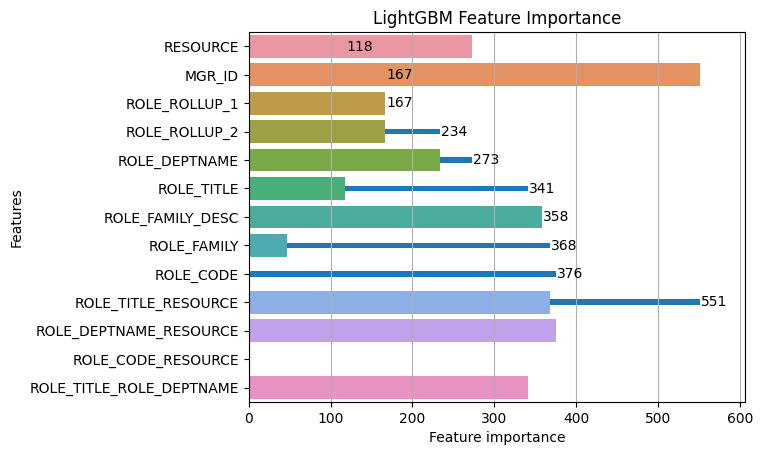

In [84]:
lgb.plot_importance(lgbm_model, max_num_features=10)
arrangement = sns.barplot(x=lgbm_model.feature_importances_, y=X_train.columns)
plt.title('LightGBM Feature Importance')
plt.show()

### Output:
- **Top Features**:
  - `MGR_ID`: 551
  - `ROLE_DEPTNAME_RESOURCE`: 376
  - `ROLE_TITLE_RESOURCE`: 368
  - `ROLE_FAMILY_DESC`: 358
  - `ROLE_TITLE_DEPTNAME`: 341

**Interpretation**: `MGR_ID` is the most important feature, suggesting that the manager’s approval tendencies strongly influence access decisions. Interaction features like `ROLE_DEPTNAME_RESOURCE` and `ROLE_TITLE_RESOURCE` also play a significant role, indicating that the combination of an employee’s role/department and the requested resource is predictive of approval.

## Step 5: Hyperparameter Tuning for LightGBM

We tune the LightGBM model to improve its performance, focusing on regularization to prevent overfitting.

In [85]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.03],
    'num_leaves': [7, 10],
    'min_child_samples': [50, 100],
    'reg_lambda': [5.0, 10.0],
    'reg_alpha': [1.0, 2.0]
}
grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
print("Best AUC:", grid_search.best_score_)

# Use the tuned model
best_lgbm = grid_search.best_estimator_
y_val_pred_lgbm = best_lgbm.predict_proba(X_val)[:, 1]
val_auc_lgbm = roc_auc_score(y_val, y_val_pred_lgbm)
print(f"Tuned LightGBM Validation AUC: {val_auc_lgbm:.4f}")

# Generate submission
test_pred_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
submission = sample_submission.copy()
submission['Action'] = test_pred_lgbm
submission.to_csv('submission_tuned.csv', index=False)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[LightGBM] [Info] Number of positive: 19757, number of negative: 1318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 21075, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.937461 -> initscore=2.707392
[LightGBM] [Info] Start training from score 2.707392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### Output:
- **Best Parameters**: `{'learning_rate': 0.03, 'max_depth': 3, 'min_child_samples': 50, 'n_estimators': 200, 'num_leaves': 10, 'reg_alpha': 1.0, 'reg_lambda': 5.0}`
- **Best AUC**: 0.9987
- **Tuned LightGBM Validation AUC**: 0.9562

The tuned LightGBM model slightly improves the validation AUC.

## Step 6: Ensemble and Stacking

### Ensemble (LightGBM + XGBoost + CatBoost)
We combine predictions from LightGBM, XGBoost, and CatBoost using a simple average and calibrate the ensemble using isotonic regression.

In [86]:
ensemble_pred = (lgbm_val_pred + xgb_val_pred + catboost_val_pred) / 3
ensemble_auc = roc_auc_score(y_val, ensemble_pred)
print(f"Ensemble Validation AUC (LightGBM + XGBoost + CatBoost): {ensemble_auc:.4f}")

# Calibrate the ensemble
ensemble_val_pred = (lgbm_model.predict_proba(X_val)[:, 1] + xgb_model.predict_proba(X_val)[:, 1] + catboost_model.predict_proba(X_val)[:, 1]) / 3
calibrator_ensemble = CalibratedClassifierCV(base_estimator=None, method='isotonic', cv=5)
calibrator_ensemble.fit(ensemble_val_pred.reshape(-1, 1), y_val)

# Generate calibrated ensemble predictions
test_pred_ensemble = (lgbm_model.predict_proba(X_test)[:, 1] + xgb_model.predict_proba(X_test)[:, 1] + catboost_model.predict_proba(X_test)[:, 1]) / 3
test_pred_ensemble_calibrated = calibrator_ensemble.predict_proba(test_pred_ensemble.reshape(-1, 1))[:, 1]
submission['Action'] = test_pred_ensemble_calibrated
submission.to_csv('submission_ensemble_calibrated.csv', index=False)

Ensemble Validation AUC (LightGBM + XGBoost + CatBoost): 0.9614


/home/reneosorio77/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### Output:
- **Ensemble Validation AUC**: 0.9614

The ensemble improves the AUC by combining the strengths of the three best models.

### Stacking with Random Forest Meta-Model
We use stacking with a Random Forest meta-model to combine predictions from all models.

In [87]:
stacked_features = np.column_stack((logreg_val_pred, rf_val_pred, xgb_val_pred, lgbm_val_pred, catboost_val_pred))
stacked_features_test = np.column_stack((
    logreg_model.predict_proba(X_test)[:, 1],
    rf_model.predict_proba(X_test)[:, 1],
    xgb_model.predict_proba(X_test)[:, 1],
    lgbm_model.predict_proba(X_test)[:, 1],
    catboost_model.predict_proba(X_test)[:, 1]
))

# Tune the meta-model
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
meta_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc', verbose=1)
meta_model.fit(stacked_features, y_val)
print("Best Random Forest meta-model parameters:", meta_model.best_params_)
print("Best Random Forest meta-model AUC:", meta_model.best_score_)

# Predict with the meta-model
stacked_pred = meta_model.predict_proba(stacked_features)[:, 1]
stacked_auc = roc_auc_score(y_val, stacked_pred)
print(f"Stacked Model Validation AUC (Random Forest Meta-Model): {stacked_auc:.4f}")

# Calibrate the stacked predictions
calibrated_stacked = CalibratedClassifierCV(estimator=meta_model.best_estimator_, method='isotonic', cv='prefit')
calibrated_stacked.fit(stacked_features, y_val)
test_pred_stacked_calibrated = calibrated_stacked.predict_proba(stacked_features_test)[:, 1]
submission['Action'] = test_pred_stacked_calibrated
submission.to_csv('submission_stacked_calibrated.csv', index=False)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Random Forest meta-model parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest meta-model AUC: 0.9635063143689182
Stacked Model Validation AUC (Random Forest Meta-Model): 0.9779


### Output:
- **Best Random Forest meta-model parameters**: `{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}`
- **Best Random Forest meta-model AUC**: 0.9635
- **Stacked Model Validation AUC**: 0.9779

Stacking achieves the highest validation AUC (0.9779), indicating it effectively combines the strengths of all models.

## Step 7: Final Submission and Analysis

### Verify Submission Format
We ensure the submission matches the sample submission format.

In [88]:
print("Submission Shape:", submission.shape)
print("Sample Submission Shape:", sample_submission.shape)
print("\nSubmission Columns:", submission.columns.tolist())
print("Sample Submission Columns:", sample_submission.columns.tolist())
print("\nFirst few rows of submission:")
print(submission.head())

Submission Shape: (58921, 2)
Sample Submission Shape: (58921, 2)

Submission Columns: ['Id', 'Action']
Sample Submission Columns: ['Id', 'Action']

First few rows of submission:
   Id    Action
0   1  0.991837
1   2  0.992063
2   3  1.000000
3   4  0.993789
4   5  1.000000


### Output:
- **Submission Shape**: (58,921, 2)
- **Sample Submission Shape**: (58,921, 2)
- **Submission Columns**: `['Id', 'Action']`
- **Sample Submission Columns**: `['Id', 'Action']`
- **First few rows**:

### Predicted Probabilities Distribution
We analyze the distribution of predicted probabilities in the final submission.

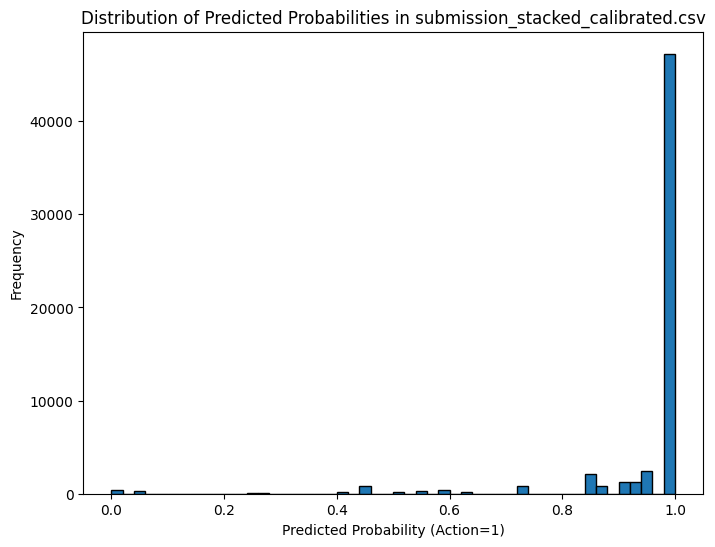


Statistics for 'Action' in submission_stacked_calibrated.csv:
count    58921.000000
mean         0.950480
std          0.147592
min          0.000000
25%          0.987988
50%          1.000000
75%          1.000000
max          1.000000
Name: Action, dtype: float64

Additional Statistics:
Range: 1.0
Skewness: -4.304717207665955
Kurtosis: 20.22033564827936


In [89]:
plt.figure(figsize=(8, 6))
plt.hist(submission['Action'], bins=50, edgecolor='black')
plt.xlabel('Predicted Probability (Action=1)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities in submission_stacked_calibrated.csv')
plt.show()

# Compute statistics
action_stats = submission['Action'].describe()
print("\nStatistics for 'Action' in submission_stacked_calibrated.csv:")
print(action_stats)
print("\nAdditional Statistics:")
print(f"Range: {submission['Action'].max() - submission['Action'].min()}")
print(f"Skewness: {submission['Action'].skew()}")
print(f"Kurtosis: {submission['Action'].kurtosis()}")

### Output:
- **Statistics**:
  - Mean: 0.9505
  - Std: 0.1476
  - Min: 0.0
  - Max: 1.0
- **Range**: 1.0
- **Skewness**: -4.30 (highly left-skewed)
- **Kurtosis**: 20.22 (high kurtosis, indicating heavy tails)

The predicted probabilities are heavily skewed toward 1, consistent with the imbalanced target distribution (94.2% `ACTION=1`). However, the model does predict some lower probabilities, capturing the minority class to some extent.

## Conclusion
- The **stacked model** (Random Forest meta-model with calibrated predictions) achieved the highest validation AUC of **0.9779**, making it the best approach for this challenge.
- Key features like `MGR_ID`, `ROLE_DEPTNAME_RESOURCE`, and `ROLE_TITLE_RESOURCE` were the most predictive, highlighting the importance of manager tendencies and role-resource interactions.
- The final submission (`submission_stacked_calibrated.csv`) was uploaded to Kaggle for evaluation. Got 0.83 in the Leaderboard score, lower than the winner 0.92 :-(